In [1]:
#| default_exp linops

In [2]:
#| export

import numpy as np
import matplotlib.pyplot as plt

import igl

In [72]:
#| export

import jax
import jax.numpy as jnp

import lineax

import functools

In [4]:
#| export

from jaxtyping import Float 

In [5]:
#| export

import sys
from pathlib import Path

sys.path.insert(0, str(Path("..").resolve()))

from triangulax import trigonometry as trig
from triangulax.triangular import TriMesh
from triangulax import mesh as msh

In [6]:
#| hide

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_log_compiles', False) # use this to log JAX JIT compilations.

In [7]:
#| hide

import jaxtyping


In [8]:
#| hide

%load_ext jaxtyping 
%jaxtyping.typechecker beartype.beartype

# enables type checking. does not work for some cells (vmapping and loading/saving). For those, %unload_ext jaxtyping 


In [50]:
# load test data

mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = msh.HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = msh.GeomMesh(*hemesh.n_items, mesh.vertices, mesh.face_positions)

mesh_3d = TriMesh.read_obj("test_meshes/disk.obj", dim=3)
geommesh_3d = msh.GeomMesh(*hemesh.n_items, mesh_3d.vertices, mesh_3d.face_positions)

  o flat_tri_ecmc
  o flat_tri_ecmc


## Adjacency-like operators on half-edge meshes

Using the `HeMesh` data structure, we can efficiently "traverse" our mesh. Using such traversals, one can express many of the key _linear operators_ defined by the mesh adjacency structure, for example
- Sum over all half-edges "incoming" to a vertex (special case: _count_ the incoming edges, i.e., compute the coordination number) 
- Compute the finite-element gradient of a function defined on vertices

These operations can be done efficiently using a "gather/scatter" approach, see [`jax.numpy.ndarray.at`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html#jax.numpy.ndarray.at). There is no need to explicitly instantiate a matrix for the operators.

In [66]:
#| export

## averaging from faces to vertices, and vice versa. Compare igl.average_onto_faces and igl.average_onto_vertices

def average_vertices_to_faces(hemesh: msh.HeMesh,
                              vertex_field: Float[jax.Array, "n_vertices ..."],
                              ) -> Float[jax.Array, "n_faces ..."]:
    """Average per-vertex field onto faces (uniform weights)."""
    faces = hemesh.faces
    return jnp.mean(vertex_field[faces], axis=1)


def average_faces_to_vertices(hemesh: msh.HeMesh,
                              vertices: Float[jax.Array, "n_vertices dim"],
                              face_field: Float[jax.Array, "n_faces ..."],
                              ) -> Float[jax.Array, "n_vertices ..."]:
    """Average per-face field onto vertices, weighted by triangle area."""
    faces = hemesh.faces
    v0, v1, v2 = (vertices[faces[:, 0]], vertices[faces[:, 1]], vertices[faces[:, 2]])
    areas = jax.vmap(trig.get_triangle_area)(v0, v1, v2)

    weighted = face_field * areas.reshape((hemesh.n_faces,) + (1,) * (face_field.ndim - 1))
    weighted_faces = jnp.broadcast_to(weighted[:, None, ...], faces.shape + face_field.shape[1:])
    area_faces = jnp.broadcast_to(areas[:, None], faces.shape)

    out_shape = (hemesh.n_vertices,) + face_field.shape[1:]
    v_field = jnp.zeros(out_shape, dtype=face_field.dtype)
    v_area = jnp.zeros((hemesh.n_vertices,), dtype=areas.dtype)

    v_field = v_field.at[faces].add(weighted_faces)
    v_area = v_area.at[faces].add(area_faces)

    denom_shape = (hemesh.n_vertices,) + (1,) * (face_field.ndim - 1)
    return v_field / jnp.clip(jnp.reshape(v_area, denom_shape), 1e-12)

In [67]:
# tests vs libigl
key = jax.random.PRNGKey(123)

u_v = jax.random.normal(key, (hemesh.n_vertices,))
faces_avg_jax = average_vertices_to_faces(hemesh, u_v)
faces_avg_igl = igl.average_onto_faces(np.asarray(hemesh.faces), np.asarray(u_v))

rel_err_faces = np.linalg.norm(np.asarray(faces_avg_jax) - faces_avg_igl) / np.linalg.norm(faces_avg_igl)
print("vertex->face rel. error:", rel_err_faces)

u_f = jax.random.normal(key, (hemesh.n_faces,))
verts_avg_jax = average_faces_to_vertices(hemesh, geommesh.vertices, u_f)

# libigl reference using area-weighted averaging
V = np.asarray(geommesh.vertices)
F = np.asarray(hemesh.faces)
areas_np = 0.5 * igl.doublearea(V, F)
accum = np.zeros(hemesh.n_vertices)
area_accum = np.zeros(hemesh.n_vertices)
uf_np = np.asarray(u_f)
for i, f in enumerate(F):
    accum[f] += areas_np[i] * uf_np[i]
    area_accum[f] += areas_np[i]
verts_avg_ref = accum / np.maximum(area_accum, 1e-12)

rel_err_verts = np.linalg.norm(np.asarray(verts_avg_jax) - verts_avg_ref) / np.linalg.norm(verts_avg_ref)
print("face->vertex rel. error:", rel_err_verts)

vertex->face rel. error: 1.0413393664022524e-16
face->vertex rel. error: 1.3698911362107636e-16


### Computing cell areas, perimeters, etc via corners

To compute, for instance, the cell area using the shoelace formula, you need to iterate around the faces adjacent to a vertex. This is not straightforward to vectorize because the number of adjacent faces per vertex can vary (there can be 5-, 6-, 7-sided cells etc.). One way to solve this is a scheme in which the lists of adjacent faces are "padded" in some manner, so that they are all the same length. This is cumbersome.
Instead, let us split all "cell-based" quantities into contributions from "corners", i.e., half-edges, like this:

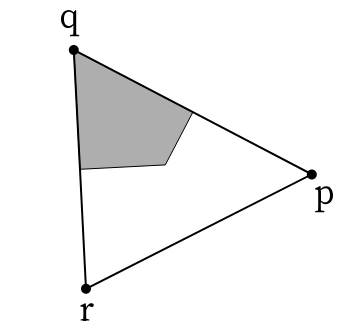
Source: [CGAL](https://doc.cgal.org/latest/Weights/group__PkgWeightsRefVoronoiRegionWeights.html)

To compute the total area, we can sum over all half-edges $(r,p)$ opposite to a vertex $q$.
Numerically, this can be achieved efficiently using gather/scatter operations.

In [9]:
#| export

def sum_he_to_vertex_incoming(hemesh: msh.HeMesh, he_field: Float[jax.Array, "n_hes ..."]
                              ) -> Float[jax.Array, "n_vertices ..."]:
    """
    Sum a half-edge field onto destination vertices.

    hemesh: connectivity information
    he_field: (n_hes,) or (n_hes, d) array
    """
    out_shape = (hemesh.n_vertices,) + he_field.shape[1:]  # supports scalar or vector fields
    v_field = jnp.zeros(out_shape, dtype=he_field.dtype)
    # Scatter-add: for each half-edge h, add he_field[h] to v_field[dest[h]]
    return v_field.at[hemesh.dest].add(he_field)

def sum_he_to_vertex_opposite(hemesh: msh.HeMesh, he_field: Float[jax.Array, "n_hes ..."]
                              ) -> Float[jax.Array, "n_vertices ..."]:
    """
    Sum a half-edge field onto opposite vertices.

    Attention: can include boundary half-edges!

    hemesh: connectivity information
    he_field: (n_hes,) or (n_hes, d) array
    """
    out_shape = (hemesh.n_vertices,) + he_field.shape[1:]  # supports scalar or vector fields
    v_field = jnp.zeros(out_shape, dtype=he_field.dtype)
    return v_field.at[hemesh.dest[hemesh.nxt]].add(he_field)


In [11]:
#| export

def get_cell_areas(geommesh: msh.GeomMesh, hemesh: msh.HeMesh) -> Float[jax.Array, " n_vertices"]:
    """
    Compute areas of cells by mesh traversal (don't use for simulation, inefficient).

    Boundary vertices get area 0.
    """
    areas = np.zeros(hemesh.n_vertices)
    bdry = hemesh.is_bdry
    for v in range(hemesh.n_vertices):
        if bdry[v]:
            areas[v] = 0
        else:
            adjacent_faces = hemesh.heface[hemesh.iterate_around_vertex(v)]
            polygon = geommesh.face_positions[adjacent_faces]
            areas[v] = trig.get_polygon_area(polygon)
    return jnp.array(areas)

In [12]:
## Let's use the adjacency matrix to compute the area of all cells. First, compute all corner areas

a, b, c = (hemesh.dest[hemesh.nxt], hemesh.dest[hemesh.prv], hemesh.dest)

corner_areas = jax.vmap(trig.get_voronoi_corner_area)(geommesh.vertices[a], geommesh.vertices[b], geommesh.vertices[c])
cell_areas_corner = sum_he_to_vertex_opposite(hemesh, corner_areas)
cell_areas_corner = cell_areas_corner.at[hemesh.is_bdry].set(0)

In [13]:
# for comparison, compute the areas by mesh traversal

cell_areas_iterative = -1*get_cell_areas(geommesh, hemesh)
np.abs(cell_areas_iterative-cell_areas_corner).max() # works!

np.float64(0.42505900310931344)

In [68]:
#| export

def get_coordination_number(hemesh: msh.HeMesh) -> Float[jax.Array, " n_vertices"]:
    return sum_he_to_vertex_incoming(hemesh, jnp.ones(hemesh.n_hes))

In [69]:
# using the gather/scatter trick, we can also compute the coordination number of each vertex

get_coordination_number(hemesh)

Array([4., 6., 6., 7., 6., 6., 6., 6., 6., 4., 4., 6., 6., 5., 6., 6., 6.,
       5., 5., 6., 3., 4., 6., 6., 6., 7., 5., 6., 6., 7., 7., 6., 4., 4.,
       3., 7., 6., 6., 5., 7., 6., 6., 6., 6., 7., 5., 4., 5., 5., 6., 6.,
       7., 7., 5., 6., 6., 7., 5., 3., 5., 7., 6., 5., 6., 5., 6., 7., 6.,
       5., 4., 5., 5., 6., 6., 6., 6., 6., 7., 6., 6., 4., 6., 6., 5., 6.,
       4., 4., 6., 6., 6., 7., 4., 6., 6., 6., 5., 6., 6., 6., 4., 4., 6.,
       6., 6., 6., 7., 6., 4., 4., 5., 4., 4., 3., 4., 4., 3., 4., 3., 5.,
       4., 3., 4., 3., 5., 6., 6., 6., 6., 6., 6., 4.], dtype=float64)

### Finite-element gradient and cotan-Laplacian

Next, we implement gradient (per-vertex scalar field -> per-face vector field) and the cotan-Laplacian (vertex -> vertex) using gather/scatter ops like above. The cotan-Laplacian is the discretization of the Laplace Beltrami operator on a triangular mesh.

In both cases, we start with a scalar field $u_i$ defined per vertex $i$ of the triangulation. The finite-element gradient is defined for each face $ijk$, like so:
$$ 
(\nabla u)_{ijk} = \sum_{l\in \{i,j,k\}} u_l \nabla\phi_l
$$
where $\nabla\phi_\alpha$ is the gradient of a linear finite element test function and takes the value
$$
    \nabla\phi_i = \tfrac{1}{2a_{ijk}} (\mathbf{v}_k-\mathbf{v}_j)^\perp
$$
plus cyclic permutations. Here, $a_{ijk}$ is the triangle area, $\mathbf{v}_i$ are the vertex positions, and $()^\perp$ denotes rotation by 90 degrees (in 3D, you rotate about the triangle normal).

The cota-Laplacian computes the following per-vertex field:
$$
(\Delta u)_i = \frac{1}{2} \sum_{j} (\cot\alpha_j +\cot\beta_j) (u_j-u_i)
$$ 
where the sum is over adjacent vertices, and $\alpha_j, \beta_j$ are the two triangle angles "opposite" to the edge $ij$.

To check for correctness, we can compare with [this `libgigl` tutorial](https://libigl.github.io/libigl-python-bindings/tut-chapter1/), using the test mesh and some random test fields.



In [15]:
#| export

def compute_cotan_laplace(hemesh: msh.HeMesh, vertices: Float[jax.Array, "n_vertices dim"],
                          vertex_field: Float[jax.Array, "n_vertices ..."]
                          ) -> Float[jax.Array, "n_vertices ..."]:
    """
    Compute cotangent laplacian of a per-vertex field (natural boundary conditions).
    """
    v_orig = vertices[hemesh.orig]
    v_dest = vertices[hemesh.dest]
    v_opp = vertices[hemesh.dest[hemesh.nxt]]

    vec1 = v_orig - v_opp
    vec2 = v_dest - v_opp
    cot = jax.vmap(trig.get_cot_between_vectors)(vec1, vec2)
    cot = jnp.where(hemesh.heface == -1, 0.0, cot)

    cot_sum = cot + cot[hemesh.twin]
    w_edge = 0.5 * cot_sum

    diff = vertex_field[hemesh.dest] - vertex_field[hemesh.orig]
    w_shape = (hemesh.n_hes,) + (1,) * (vertex_field.ndim - 1)
    weighted_diff = jnp.reshape(w_edge, w_shape) * diff

    out_shape = (hemesh.n_vertices,) + vertex_field.shape[1:]
    lap = jnp.zeros(out_shape, dtype=vertex_field.dtype)
    return lap.at[hemesh.orig].add(weighted_diff)

In [16]:
# Test against libigl cotmatrix (natural boundary conditions)
key = jax.random.PRNGKey(0)
u = jax.random.normal(key, (hemesh.n_vertices,))
u_vec = jax.random.normal(key, (hemesh.n_vertices, 3))

L = igl.cotmatrix(np.asarray(geommesh.vertices), np.asarray(hemesh.faces))

lap_jax = compute_cotan_laplace(hemesh, geommesh.vertices, u)
lap_igl = L @ np.asarray(u)

rel_err = np.linalg.norm(np.asarray(lap_jax) - lap_igl) / np.linalg.norm(lap_igl)
print("scalar field rel. error:", rel_err)

lap_jax_vec = compute_cotan_laplace(hemesh, geommesh.vertices, u_vec)
lap_igl_vec = L @ np.asarray(u_vec)

rel_err_vec = np.linalg.norm(np.asarray(lap_jax_vec) - lap_igl_vec) / np.linalg.norm(lap_igl_vec)
print("vector field rel. error:", rel_err_vec)

scalar field rel. error: 1.8132090493215958e-16
vector field rel. error: 2.0011748826180605e-16


In [46]:
#| export

def compute_gradient_2d(hemesh: msh.HeMesh, vertices: Float[jax.Array, "n_vertices 2"],
                        vertex_field: Float[jax.Array, "n_vertices ..."]
                        ) -> Float[jax.Array, "n_faces 2 ..."]:
    """Compute the linear finite-element gradient (constant per face)."""
    faces = hemesh.faces
    v0, v1, v2 = (vertices[faces[:, 0]], vertices[faces[:, 1]], vertices[faces[:, 2]])

    area2 = jnp.cross(v1 - v0, v2 - v0)
    area2_safe = jnp.where(jnp.abs(area2) > 1e-12, area2, 1.0)

    grad_phi0 = trig.get_perp_2d(v1 - v2) / area2_safe[:, None]
    grad_phi1 = trig.get_perp_2d(v2 - v0) / area2_safe[:, None]
    grad_phi2 = trig.get_perp_2d(v0 - v1) / area2_safe[:, None]

    mask = (jnp.abs(area2) > 1e-12)[:, None]
    grad_phi0 = grad_phi0 * mask
    grad_phi1 = grad_phi1 * mask
    grad_phi2 = grad_phi2 * mask

    grads = jnp.stack([grad_phi0, grad_phi1, grad_phi2], axis=1)
    vals = vertex_field[faces]
    return jnp.einsum("fvd,fv...->fd...", grads, vals)


def compute_gradient_3d(hemesh: msh.HeMesh, vertices: Float[jax.Array, "n_vertices 3"],
                        vertex_field: Float[jax.Array, "n_vertices ..."]
                        ) -> Float[jax.Array, "n_faces 3 ..."]:
    """Compute the linear finite-element gradient (constant per face)."""
    faces = hemesh.faces
    v0, v1, v2 = (vertices[faces[:, 0]], vertices[faces[:, 1]], vertices[faces[:, 2]])

    n = jnp.cross(v1 - v0, v2 - v0)
    area2 = jnp.linalg.norm(n, axis=-1)
    area2_sq_safe = jnp.where(area2 > 1e-12, area2**2, 1.0)
    grad_phi0 = jnp.cross(v1 - v2, n) / area2_sq_safe[:, None]
    grad_phi1 = jnp.cross(v2 - v0, n) / area2_sq_safe[:, None]
    grad_phi2 = jnp.cross(v0 - v1, n) / area2_sq_safe[:, None]

    mask = (area2 > 1e-12)[:, None]
    grad_phi0 = grad_phi0 * mask
    grad_phi1 = grad_phi1 * mask
    grad_phi2 = grad_phi2 * mask

    grads = jnp.stack([grad_phi0, grad_phi1, grad_phi2], axis=1)
    vals = vertex_field[faces]
    return jnp.einsum("fvd,fv...->fd...", grads, vals)

In [47]:
# here's how to compute the gradient in libigl

grad_matrix = igl.grad(np.asarray(geommesh.vertices), np.asarray(hemesh.faces))
# calculate the gradient of field by matrix multiplication
grad_igl = grad_matrix @ np.asarray(u)
# order='F' copied from igl tutorial
grad_igl = grad_igl.reshape((hemesh.n_faces, geommesh.dim), order='F')

In [48]:
grad_jax = compute_gradient_2d(hemesh, geommesh.vertices, u)

rel_err_grad = np.linalg.norm(np.asarray(grad_jax) - grad_igl) / np.linalg.norm(grad_igl)
print("gradient rel. error:", rel_err_grad)

gradient rel. error: 1.413315746703021e-16


In [49]:
# same test, in 3d

grad_matrix_3d = igl.grad(np.asarray(geommesh_3d.vertices), np.asarray(hemesh.faces))
grad_igl_3d = grad_matrix_3d @ np.asarray(u)
grad_igl_3d = grad_igl_3d.reshape((hemesh.n_faces, geommesh_3d.dim), order='F')

grad_jax_3d = compute_gradient_3d(hemesh, geommesh_3d.vertices, u)

rel_err_grad_3d = np.linalg.norm(np.asarray(grad_jax_3d) - grad_igl_3d) / np.linalg.norm(grad_igl_3d)
print("gradient rel. error:", rel_err_grad_3d)

gradient rel. error: 1.5657863888820882e-16


### Wrapping as linear operators

It's often useful to think of functions like `compute_cotan_laplace()` as a linear operator on fields on meshes. For example, imagine you want to solve the Laplace equation on a mesh with fixed vertex positions and connectivity. You will want to use a linear solver. Luckily, most such solvers only need to be able to compute the action of a linear operator on an input vector, and don't need an explicit matrix representation. 

In the JAX ecosystem, the `lineax` library defines linear solvers. We can _wrap_  `compute_cotan_laplace()` as a linear operator, which allows us to pass it into iterative linear algebra algorithms.

In [89]:
%unload_ext jaxtyping 


In [ ]:
# "bake in" the connectivity and vertex positions

laplace_op = functools.partial(compute_cotan_laplace, hemesh, geommesh.vertices)
_ = laplace_op(u)

In [105]:
# define the linear operator

laplace_op_lx = lineax.FunctionLinearOperator(laplace_op,
                                              input_structure=jax.eval_shape(laplace_op, u))